In [4]:
import matplotlib.pyplot as plt
import cv2
import json
import easyocr
import numpy as np
from PIL import Image
import pytesseract
%matplotlib inline
pytesseract.pytesseract.tesseract_cmd = r'your\path\tesseract.exe' 
#Enter the your tesseract.exe path in the section above

In [4]:
# WITH DRIVE CONNECT FOR GOOGLE COLAB USERS
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #Width of network's input image
inpHeight = 416     #Height of network's input image

In [6]:
# YOLO INPUT'S
classesFile = "yolo/classes.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n') 

modelConfiguration = "yolo/darknet-yolov3.cfg";
modelWeights = "yolo/lapi.weights";


In [7]:
# Yolo files importted and create yolo model.
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [8]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()

    return [layersNames[int(i)-1] for i in net.getUnconnectedOutLayers()]

In [184]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        #print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = int(i)
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        #print(right),print(left)
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        ret = frame.copy()
        ret = cv2.rectangle(ret, (left, top), (right, bottom), (0, 255, 0), 5)
    if cropped is not None:
        return cropped,ret,top,left,right,bottom

In [170]:
def import_plate(input_path,net):
    cap = cv2.VideoCapture(input_path)
    hasFrame, frame = cap.read() #frame: an image object from cv2
    save = frame.copy()
    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    cropped,box,top,left,right,bottom = postprocess(frame, outs)
    cropped = cv2.cvtColor(cropped,cv2.COLOR_BGR2RGB)
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    return cropped,box,top,left,right,bottom

In [171]:
def find_contours(dimensions, img):

    #Find plate contours.
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Found the contours sorted at contour areas.
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    # used draw ractangle for predicted contours
    img_copy = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        # DIMENSIONS SORTED.
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
        
            cv2.rectangle(img_copy, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
#             plt.imshow(img_copy, cmap='gray')
#             plt.title('Predict Segments')
                                 
            char = cv2.subtract(255, char)
                                 
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy)
            

            
#     plt.show()
    
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_result = np.array(img_res_copy)
    return img_result,img_copy

In [177]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                        2*LP_HEIGHT/3]
    cv2.imwrite('contour.jpg',img_binary_lp)
#     plt.imshow(img_binary_lp, cmap='gray')
#     plt.title('Contour')
#     plt.show()

    # Get contours within cropped license plate
    char_list,img_segment = find_contours(dimensions, img_binary_lp)

    return char_list,img_binary_lp,img_segment

In [113]:
def result_pytesseract(frame):
#     plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)),plt.show()
    # list2: false chars predicted list.
    list2 = []
    
    xconfig = '--psm 6  --oem 3'
    result = pytesseract.image_to_string(frame,lang='tur',config = xconfig)
    
    # Predicted false chars and deleted.
    result = list(result)
    try:
        for a in range(len(result)-1,-1,-1):
            for j in range(0,len(false_chars)):
                if result[a] == false_chars[str(j)]:
                    list2.append(a)
        for z in range(0,len(list2)):
            del result[list2[z]]
        del result[len(result)-1]
        del result[len(result)-1]
    except:
    #Cannot be found first and end character letter. Predicted chars and deleted.
    try:
        for e in range(0,len(charss)):
            if charss[str(e)] == result[0]:
                del result[0]
            if charss[str(e)] == result[len(result)-1]:
                del result[len(result)-1]
    except:
        pass
    result = ''.join(result)
    return result

In [114]:
def result_easyocr(char):
    reader = easyocr.Reader(['tr'])
    # plate: predicted letter and digits result.
    plate=[]
    
    for i in range(0,len(char)):
        
        # for easyocr working. first array to img and convert rgb. third convert array.
        imge_out = Image.fromarray(char[i].astype('uint8'))
        img_as_img = imge_out.convert("RGB")
        frame = np.array(img_as_img)
        
        # if easyocr not found character, pass the code.
        try:
            result = reader.readtext(frame)[0][1]
            #not letter lowcase.
            if result == 'u':
                result = 'U'
        except:
            result=''
        plate.append(str(result))
    
    plate_number = ''.join(plate)
    return plate_number

In [5]:
# .json datas imports.

#true_plates = ['35VP404','34SN722','23K5537','06CRL881','34ESM084','09JN999','55AAJ339','59HP559','34EMG837','06CKP307','34ESD505','07AJM829','34BDU695','09ADY288','09AGF808','23ACM279','34AGF767','58ADE876','35BBU743','35BBY448','34ESZ316','16AKK506','34DGU097','34BMU534','07AUJ687','34CSL717','34RR3289','34SA1903','01EH993','07AAK765']
with open('json_data/plates_data.json') as f:
    true_plates = json.load(f)

# false_chars = ['!','”', "'", '^', '+', '%', '&', '/', '(', ')', '=', '?', '_', '"', '#', '$', '{', '[', ']', '}', '\\', '|', '<', '>', '/', '*', '-',' ']
with open('json_data/false_data.json') as f:
    false_chars = json.load(f)

# charss = ['Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P', 'Ğ', 'Ü', 'A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'Ş', 'İ', 'Z', 'X', 'C', 'V', 'B', 'N', 'M', 'Ö', 'Ç']
with open('json_data/chars_data.json') as f:
    charss = json.load(f)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


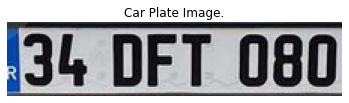

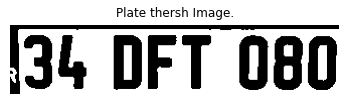

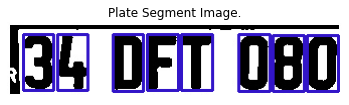

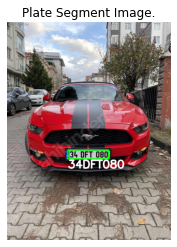

easyocr: 34DFT080
pytesserract: 134DFT080
True Plate: 34DFT080
Ocr_Succesfully


In [188]:
true_plates='34DFT080'
# cropped : plate found the car. 
cropped,box,top,left,right,bottom = import_plate('test/predict2.jpg',net)

# chars split the plate.
char,frame,image_segment = segment_characters(cropped)
    
# easyocr result
result_ocr = result_easyocr(char)
    
# pytesseract result
result_py = result_pytesseract(frame)

cv2.putText(box, true_plates, (left,bottom+50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),8 )
plt.imshow(cropped),plt.title('Car Plate Image.'),plt.axis('off'),plt.show()
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)),plt.title('Plate thersh Image.'),plt.axis('off'),plt.show()
plt.imshow(image_segment),plt.title('Plate Segment Image.'),plt.axis('off'),plt.show()
plt.imshow(cv2.cvtColor(box,cv2.COLOR_BGR2RGB)),plt.title('Plate Segment Image.'),plt.axis('off'),plt.show()

# cv2.imwrite('end_images/cropped_mustang.jpg',cropped)
# cv2.imwrite('end_images/plate_mustang.jpg',frame)
# cv2.imwrite('end_images/predicted_char_mustang.jpg',image_segment)
# cv2.imwrite('end_images/result_mustang.jpg',box)

print('easyocr: ' + result_ocr)
print('pytesserract: ' + result_py)
print('True Plate: ' + true_plates)
    
if result_ocr == true_plates:
    print('Ocr_Succesfully')
if result_py == true_plates:
    print('Pytesseract_Succesfully')

In [191]:
list0 = []
list1 = []
for i in range(1,31):
    # cropped : plate found the car. 
    cropped,_,_,_,_,_ = import_plate('test/test0x0'+str(i)+'.jpg',net)
    
    # chars split the plate.
    char,frame,_ = segment_characters(cropped)
    
    # easyocr result
    result_ocr = result_easyocr(char)
    
    # pytesseract result
    result_py = result_pytesseract(frame)
    
    print('easyocr: ' + result_ocr)
    print('pytesserract: ' + result_py)
    print('True Plate: ' + true_plates[str(i-1)])
    
    if result_ocr == true_plates[str(i-1)]:
        print('Ocr_Succesfully')
        list0.append(i)
    if result_py == true_plates[str(i-1)]:
        print('Pytesseract_Succesfully')
        list1.append(i)


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 35YP404
pytesserract: 35VP404
True Plate: 35VP404
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34SN722
pytesserract: 34SN722
True Plate: 34SN722
Ocr_Succesfully
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 23K5537
pytesserract: 823K55371
True Plate: 23K5537
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 06CRL881
pytesserract: 106CRL681
True Plate: 06CRL881
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34ESH084
pytesserract: 34ESM084
True Plate: 34ESM084
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 09J999
pytesserract: 09JN999
True Plate: 09JN999
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 55AAJ339
pytesserract: 5AAJ339
True Plate: 55AAJ339
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 59HP559
pytesserract: ğ59HP:5591
True Plate: 59HP559
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34EMG837
pytesserract: 34EMG837
True Plate: 34EMG837
Ocr_Succesfully
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 06CKP307
pytesserract: 06CKP307
True Plate: 06CKP307
Ocr_Succesfully
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34ES0505
pytesserract: 34ESD505
True Plate: 34ESD505
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 07AJM829
pytesserract: 107AJM829
True Plate: 07AJM829
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34BDU695
pytesserract: 34BDU695
True Plate: 34BDU695
Ocr_Succesfully
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 09ADY288
pytesserract: 09ADY288
True Plate: 09ADY288
Ocr_Succesfully
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 09AGF808
pytesserract: 9AGF808
True Plate: 09AGF808
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 23ACM279
pytesserract: 323ACM279
True Plate: 23ACM279
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34AGF167
pytesserract: 34AGF767
True Plate: 34AGF767
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 58ADE876
pytesserract: 58ADE8761
True Plate: 58ADE876
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 35BBU743
pytesserract: 135BBU743
True Plate: 35BBU743
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 35BBY448
pytesserract: 35BBY448
True Plate: 35BBY448
Ocr_Succesfully
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34ESZ316
pytesserract: 34ESZ316
True Plate: 34ESZ316
Ocr_Succesfully
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 164KK506
pytesserract: 16AKK506
True Plate: 16AKK506
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34D6U097
pytesserract: 34DGU097
True Plate: 34DGU097
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34BMU534
pytesserract: 234BMU534
True Plate: 34BMU534
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 07AUJ687
pytesserract: 07AUJ687
True Plate: 07AUJ687
Ocr_Succesfully
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34CSL711
pytesserract: 34CSL717
True Plate: 34CSL717
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34RR3289
pytesserract: 3LRR3289
True Plate: 34RR3289
Ocr_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 34SA1903
pytesserract: 34SA1903
True Plate: 34SA1903
Ocr_Succesfully
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 01993
pytesserract: 01EH993
True Plate: 01EH993
Pytesseract_Succesfully


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


easyocr: 07AAK765
pytesserract: 307AAK765
True Plate: 07AAK765
Ocr_Succesfully


In [192]:
print('easyocr true predicted test image numbers: ' + str(list0))
print('Pytesseract True predicted test image numbers: ' + str(list1))
print('Easyocr Model accuracy: %' + str(round(((len(list0))/31)*100,2)))
print('Pytesseract Model accuracy: %' + str(round(((len(list1))/31)*100,2)))

easyocr true predicted test image numbers: [2, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 24, 25, 27, 28, 30]
Pytesseract True predicted test image numbers: [1, 2, 5, 6, 9, 10, 11, 13, 14, 17, 20, 21, 22, 23, 25, 26, 28, 29]
Easyocr Model accuracy: %67.74
Pytesseract Model accuracy: %58.06
